# Time Series analysis for Covid cases in Zimbabwe 

The scope of this project is to use TSA on Covid-19 dataset since 20/03/2020 - 20/03/2022 to predict the number of new cases and deaths to be recorded in the upcoming months of 2022.

### TSA Process flow 
1. Identifying components in the given dataset. These components are Trends, Seasonality, Cyclic Patterns and        Irregularity.
2. Check the stationarity of data using one of the following tests: a) Augmented-Dickey-Fuller (ADF) Test b)   Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test.
3. Converting Non-Stationarity Data into stationarity data using one of the following methods: i) Detrending ii) Differencing iii) Transformation.
4. Pre-work for AR/MA : a) Auto-correlation function (ACF) b) Particial Auto correlation function (PACF)
5. Perfom ARMA (Auto Regression Moving Average)
6. Perform ARIMA (AR + I + MA)

NB* For easy manipulation set the date column as index to your project.eg opsd_daily = opsd_daily.set_index('Date')

In [68]:
import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv(r"C:\Users\Benson\Documents\My Projects\Covid cases forecast\ZWE Covid Cases.csv")

In [3]:
df.head(10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,ZWE,Africa,Zimbabwe,3/20/2020,1,1.0,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
1,ZWE,Africa,Zimbabwe,3/21/2020,3,2.0,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2,ZWE,Africa,Zimbabwe,3/22/2020,3,0.0,NaN,NaN,NaN,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
3,ZWE,Africa,Zimbabwe,3/23/2020,3,0.0,NaN,1.0,1.0,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
4,ZWE,Africa,Zimbabwe,3/24/2020,3,0.0,NaN,1.0,0.0,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
5,ZWE,Africa,Zimbabwe,3/25/2020,3,0.0,NaN,1.0,0.0,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
6,ZWE,Africa,Zimbabwe,3/26/2020,3,0.0,0.429,1.0,0.0,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
7,ZWE,Africa,Zimbabwe,3/27/2020,5,2.0,0.571,1.0,0.0,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
8,ZWE,Africa,Zimbabwe,3/28/2020,7,2.0,0.571,1.0,0.0,NaN,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
9,ZWE,Africa,Zimbabwe,3/29/2020,7,0.0,0.571,1.0,0.0,0.143,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


#### Creating a new data frame with the components we want to build

In [4]:
dfTSA =df[['date','new_cases','new_deaths']]

In [5]:
dfTSA

,date,new_cases,new_deaths
0,3/20/2020,1.0,NaN
1,3/21/2020,2.0,NaN
2,3/22/2020,0.0,NaN
3,3/23/2020,0.0,1.0
4,3/24/2020,0.0,0.0
...,...,...,...
721,3/11/2022,0.0,0.0
722,3/12/2022,521.0,4.0
723,3/13/2022,446.0,2.0
724,3/14/2022,394.0,2.0


In [6]:
dfTSA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        726 non-null    object 
 1   new_cases   724 non-null    float64
 2   new_deaths  723 non-null    float64
dtypes: float64(2), object(1)
memory usage: 17.1+ KB


In [7]:
#dfTSA['date'] = pd.to_datetime(dfTSA['date'],format='%m%d%y')
#dfTSA['date']
#pd.to_datetime(dfTSA['date'],format='%m%d%y')
dfTSA['date'] = dfTSA['date'].astype('datetime64[ns]')
dfTSA['date'] 

C:\Users\Benson\AppData\Local\Temp/ipykernel_20960/66562712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTSA['date'] = dfTSA['date'].astype('datetime64[ns]')


0     2020-03-20
1     2020-03-21
2     2020-03-22
3     2020-03-23
4     2020-03-24
         ...    
721   2022-03-11
722   2022-03-12
723   2022-03-13
724   2022-03-14
725   2022-03-15
Name: date, Length: 726, dtype: datetime64[ns]

In [8]:
dfTSA.isna().sum()

date          0
new_cases     2
new_deaths    3
dtype: int64

#### TSA models do not support missing values (NaN) thus we have to check for missing values in our dataframe

In [9]:
dfTSA[dfTSA.isnull().any(axis=1)]

,date,new_cases,new_deaths
0,2020-03-20,1.0,NaN
1,2020-03-21,2.0,NaN
2,2020-03-22,0.0,NaN
43,2020-05-02,NaN,0.0
725,2022-03-15,NaN,0.0


Investigating more on the deaths in the month of March 2020

In [10]:
#dfTSA.new_cases=dfTSA.new_cases.fillna(0.0)
#dfTSA.new_deaths=dfTSA.new_deaths.fillna(0.0)

dfTSA[(dfTSA['date'] > '2020-03-20') & (dfTSA['date'] <= '2020-03-31')]

,date,new_cases,new_deaths
1,2020-03-21,2.0,NaN
2,2020-03-22,0.0,NaN
3,2020-03-23,0.0,1.0
4,2020-03-24,0.0,0.0
5,2020-03-25,0.0,0.0
6,2020-03-26,0.0,0.0
7,2020-03-27,2.0,0.0
8,2020-03-28,2.0,0.0
9,2020-03-29,0.0,0.0
10,2020-03-30,0.0,0.0


Since the median of the whole column is 0, its safe to assume that on the 21st and 22nd of March 2020 there were no deaths, thus we replace the NaN values with 0.

In [11]:
dfTSA.new_deaths=dfTSA.new_deaths.fillna(0.0)

C:\Users\Benson\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
dfTSA.isna().sum()

date          0
new_cases     2
new_deaths    0
dtype: int64

In [13]:
dfTSA.new_cases=dfTSA.new_cases.fillna(0.0)

In [14]:
dfTSA.isna().sum()

date          0
new_cases     0
new_deaths    0
dtype: int64

# Part 2: Exploratory Data Analysis

This part of the project will answer the following questions:

1. Which month recorded the highest new cases and deaths.
2. Is the number of new cases correlated to the number of deaths.
3. How does new cases change over time.
4. 

### Q1 Which month recorded the highest average new cases

In [15]:
dfTSA['Month']= pd.DatetimeIndex(dfTSA['date']).month_name()

C:\Users\Benson\AppData\Local\Temp/ipykernel_20960/1871449945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTSA['Month']= pd.DatetimeIndex(dfTSA['date']).month_name()


In [16]:
dfTSA

,date,new_cases,new_deaths,Month
0,2020-03-20,1.0,0.0,March
1,2020-03-21,2.0,0.0,March
2,2020-03-22,0.0,0.0,March
3,2020-03-23,0.0,1.0,March
4,2020-03-24,0.0,0.0,March
...,...,...,...,...
721,2022-03-11,0.0,0.0,March
722,2022-03-12,521.0,4.0,March
723,2022-03-13,446.0,2.0,March
724,2022-03-14,394.0,2.0,March


In [17]:
Month_avg = dfTSA.pivot_table(values="new_cases", index="Month", aggfunc="mean").sort_values("new_cases", ascending=False)

            new_cases
Month                
December  1331.451613


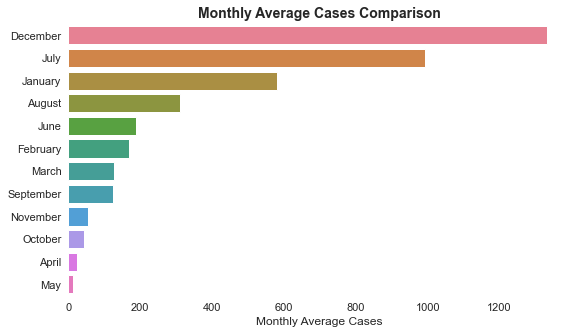

In [18]:
print(Month_avg.head(1))

sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(9,5))
ax = sns.barplot(data=Month_avg, x= "new_cases", y = Month_avg.index, orient="h")
ax.set_ylabel("")
ax.set_xlabel("Monthly Average Cases", fontsize=12)
ax.set_title("Monthly Average Cases Comparison", fontweight="bold", fontsize=14)
ax.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [19]:
Month_avg_deaths = dfTSA.pivot_table(values="new_deaths", index="Month", aggfunc="mean").sort_values("new_deaths", ascending=False)

       new_deaths
Month            
July    29.080645


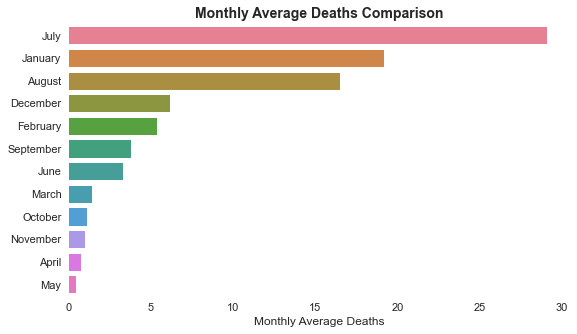

In [20]:
print(Month_avg_deaths.head(1))

sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(9,5))
ay = sns.barplot(data=Month_avg_deaths, x= "new_deaths", y = Month_avg_deaths.index)
ay.set_ylabel("")
ay.set_xlabel("Monthly Average Deaths", fontsize=12)
ay.set_title("Monthly Average Deaths Comparison", fontweight="bold", fontsize=14)
ay.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [21]:
dfTSA[dfTSA.date.dt.year==2020]

,date,new_cases,new_deaths,Month
0,2020-03-20,1.0,0.0,March
1,2020-03-21,2.0,0.0,March
2,2020-03-22,0.0,0.0,March
3,2020-03-23,0.0,1.0,March
4,2020-03-24,0.0,0.0,March
...,...,...,...,...
282,2020-12-27,114.0,8.0,December
283,2020-12-28,71.0,5.0,December
284,2020-12-29,177.0,5.0,December
285,2020-12-30,300.0,1.0,December


In [22]:
monthlyAverageDeaths2020 = dfTSA[dfTSA.date.dt.year==2020].pivot_table(values="new_deaths", index="Month", aggfunc="mean").sort_values("new_deaths", ascending=False)

        new_deaths
Month             
August    4.354839


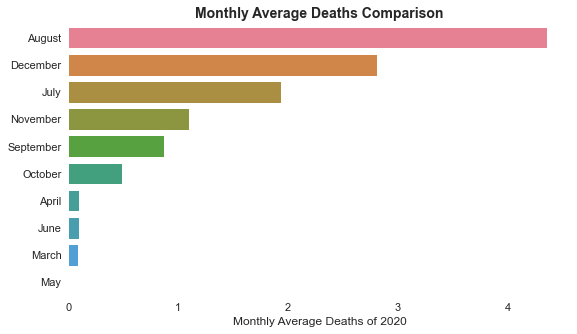

In [23]:
print(monthlyAverageDeaths2020.head(1))

sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(9,5))
ay = sns.barplot(data=monthlyAverageDeaths2020, x= "new_deaths", y = monthlyAverageDeaths2020.index)
ay.set_ylabel("")
ay.set_xlabel("Monthly Average Deaths of 2020", fontsize=12)
ay.set_title("Monthly Average Deaths Comparison", fontweight="bold", fontsize=14)
ay.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [24]:
monthlyAverageCases2020 = dfTSA[dfTSA.date.dt.year==2020].pivot_table(values="new_cases", index="Month", aggfunc="mean").sort_values("new_cases", ascending=False)

           new_cases
Month               
December  126.354839


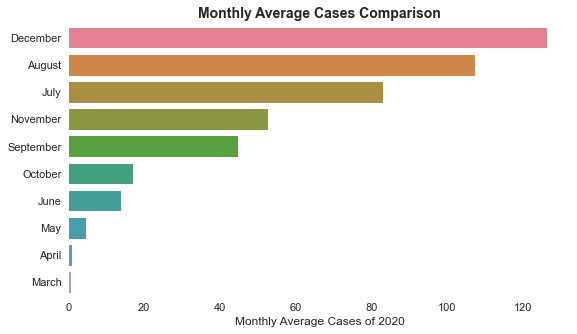

In [25]:
print(monthlyAverageCases2020.head(1))

sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(9,5))
ay = sns.barplot(data=monthlyAverageCases2020, x= "new_cases", y = monthlyAverageCases2020.index)
ay.set_ylabel("")
ay.set_xlabel("Monthly Average Cases of 2020", fontsize=12)
ay.set_title("Monthly Average Cases Comparison", fontweight="bold", fontsize=14)
ay.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [26]:
monthlyAverageDeaths2021 = dfTSA[dfTSA.date.dt.year==2021].pivot_table(values="new_deaths", index="Month", aggfunc="mean").sort_values("new_deaths", ascending=False)

       new_deaths
Month            
July    56.225806


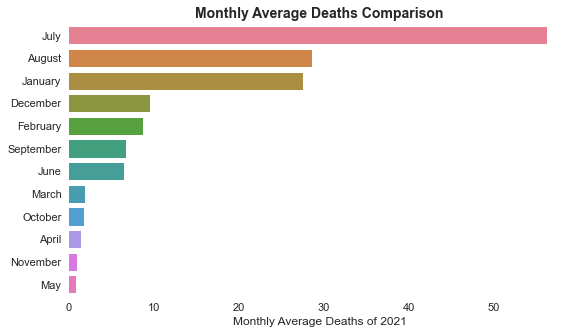

In [27]:
print(monthlyAverageDeaths2021.head(1))

sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(9,5))
ay = sns.barplot(data=monthlyAverageDeaths2021, x= "new_deaths", y = monthlyAverageDeaths2021.index)
ay.set_ylabel("")
ay.set_xlabel("Monthly Average Deaths of 2021", fontsize=12)
ay.set_title("Monthly Average Deaths Comparison", fontweight="bold", fontsize=14)
ay.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [28]:
monthlyAverageCases2021 = dfTSA[dfTSA.date.dt.year==2021].pivot_table(values="new_cases", index="Month", aggfunc="mean").sort_values("new_cases", ascending=False)

            new_cases
Month                
December  2536.548387


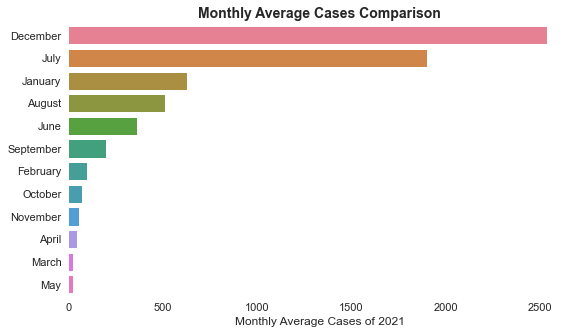

In [29]:
print(monthlyAverageCases2021.head(1))

sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(9,5))
ay = sns.barplot(data=monthlyAverageCases2021, x= "new_cases", y = monthlyAverageCases2021.index)
ay.set_ylabel("")
ay.set_xlabel("Monthly Average Cases of 2021", fontsize=12)
ay.set_title("Monthly Average Cases Comparison", fontweight="bold", fontsize=14)
ay.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

### 1. Identifying components in the given dataset. 

a. Monthly Seasonality

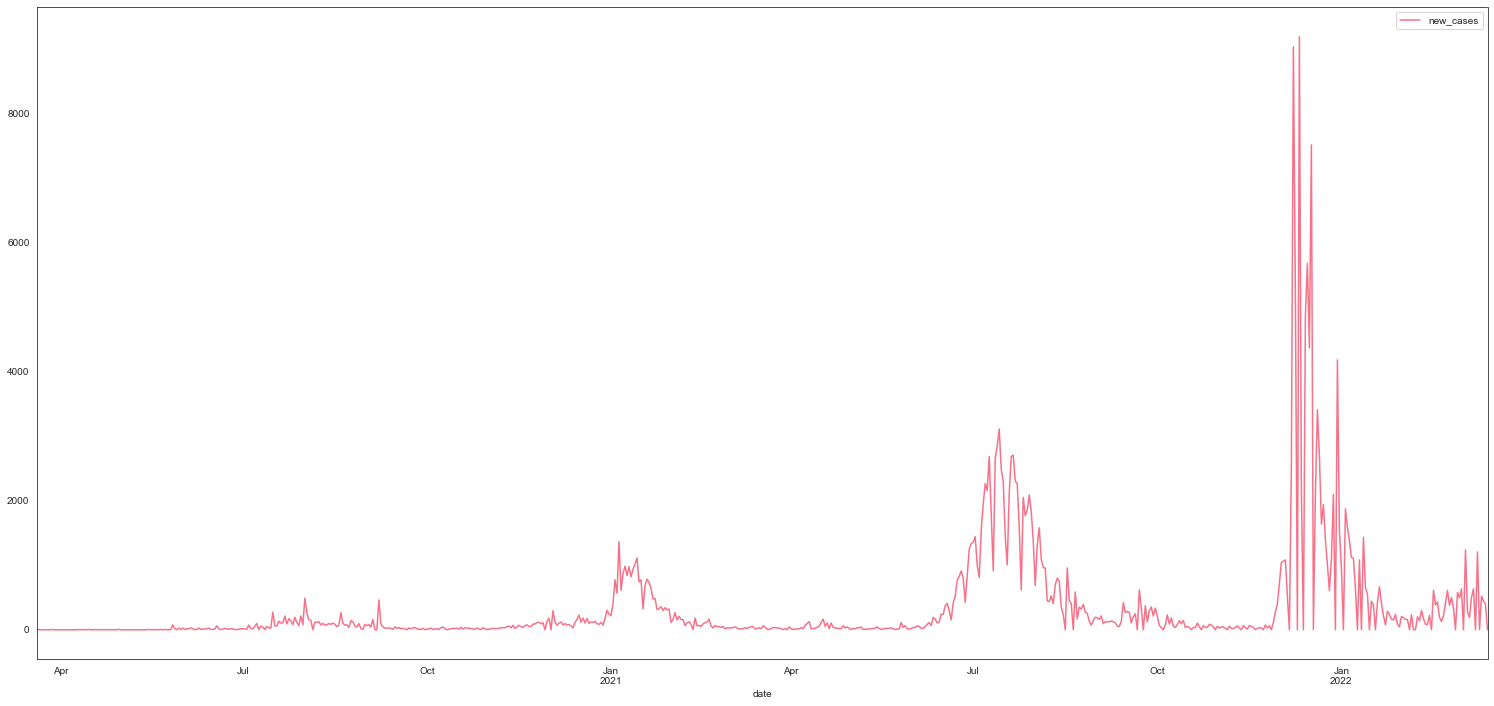

In [30]:
seasonalityTest = dfTSA.plot(x='date', y='new_cases', figsize=(26,12))

In [31]:
dfTSA= dfTSA.set_index('date')

In [32]:
dfTSA.loc['2020-05-05':'2020-06-06']

,new_cases,new_deaths,Month
date,,,
2020-05-05,0.0,0.0,May
2020-05-06,0.0,0.0,May
2020-05-07,0.0,0.0,May
2020-05-08,0.0,0.0,May
2020-05-09,1.0,0.0,May
2020-05-10,1.0,0.0,May
2020-05-11,0.0,0.0,May
2020-05-12,0.0,0.0,May
2020-05-13,1.0,0.0,May


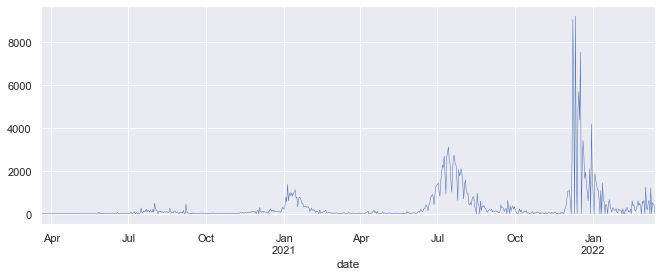

In [33]:
sns.set(rc={'figure.figsize':(11, 4)})
dfTSA['new_cases'].plot(linewidth=0.5);

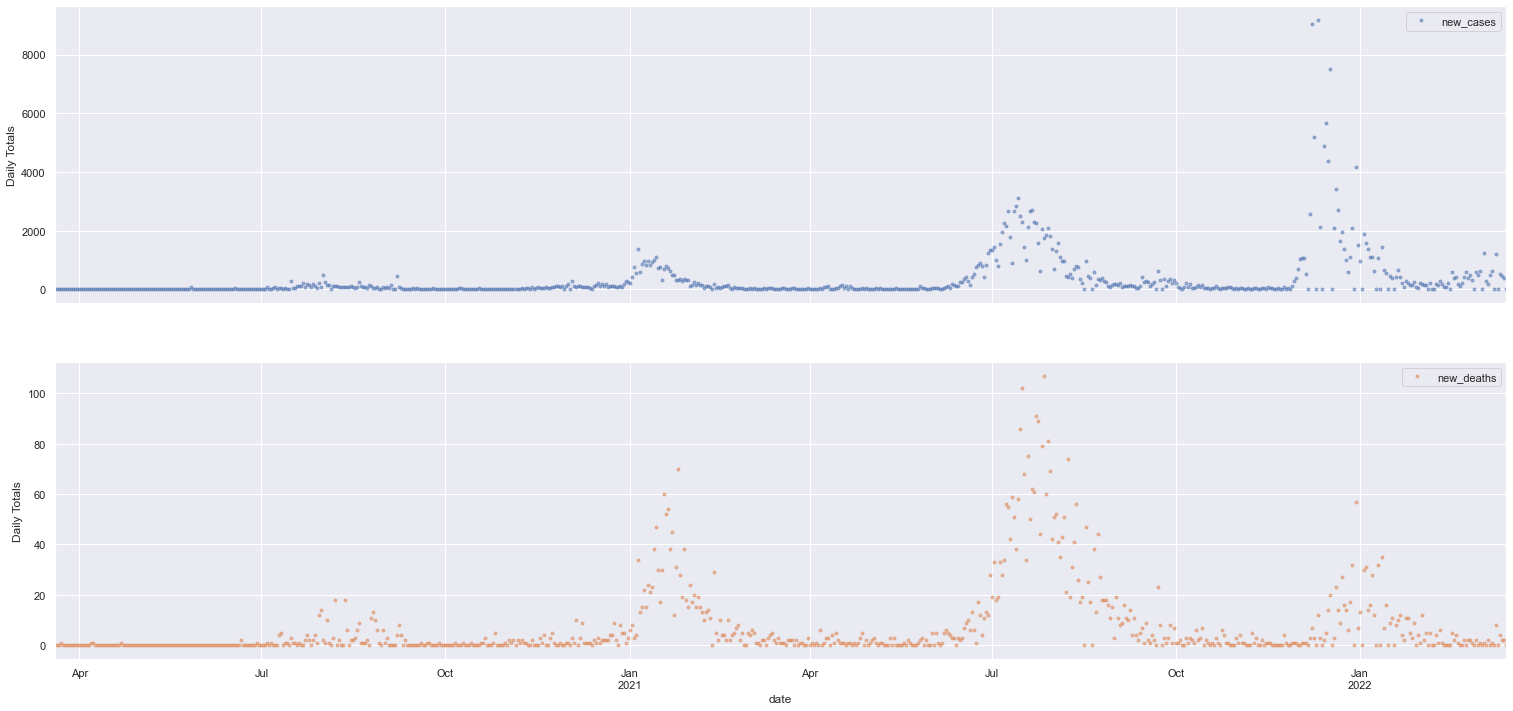

In [34]:
cols_plot = ['new_cases', 'new_deaths']
axes = dfTSA[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(26,12), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals')

From the graphs above we can see that:
1. The graph is seasonal for both cases and deaths
2. There appears to be a strong increasing trend in both deaths and cases over the months.

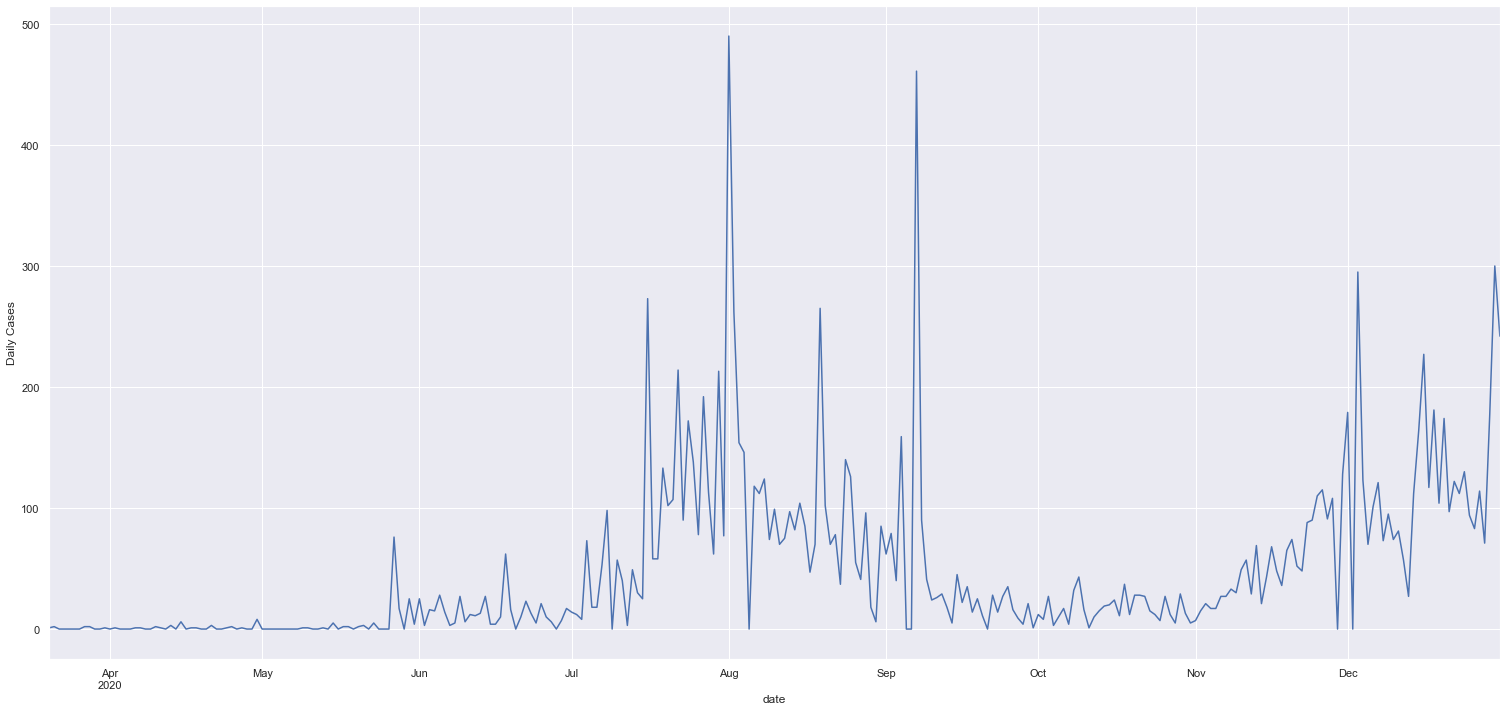

In [35]:
ax = dfTSA.loc['2020', 'new_cases'].plot(figsize=(26,12))
ax.set_ylabel('Daily Cases');

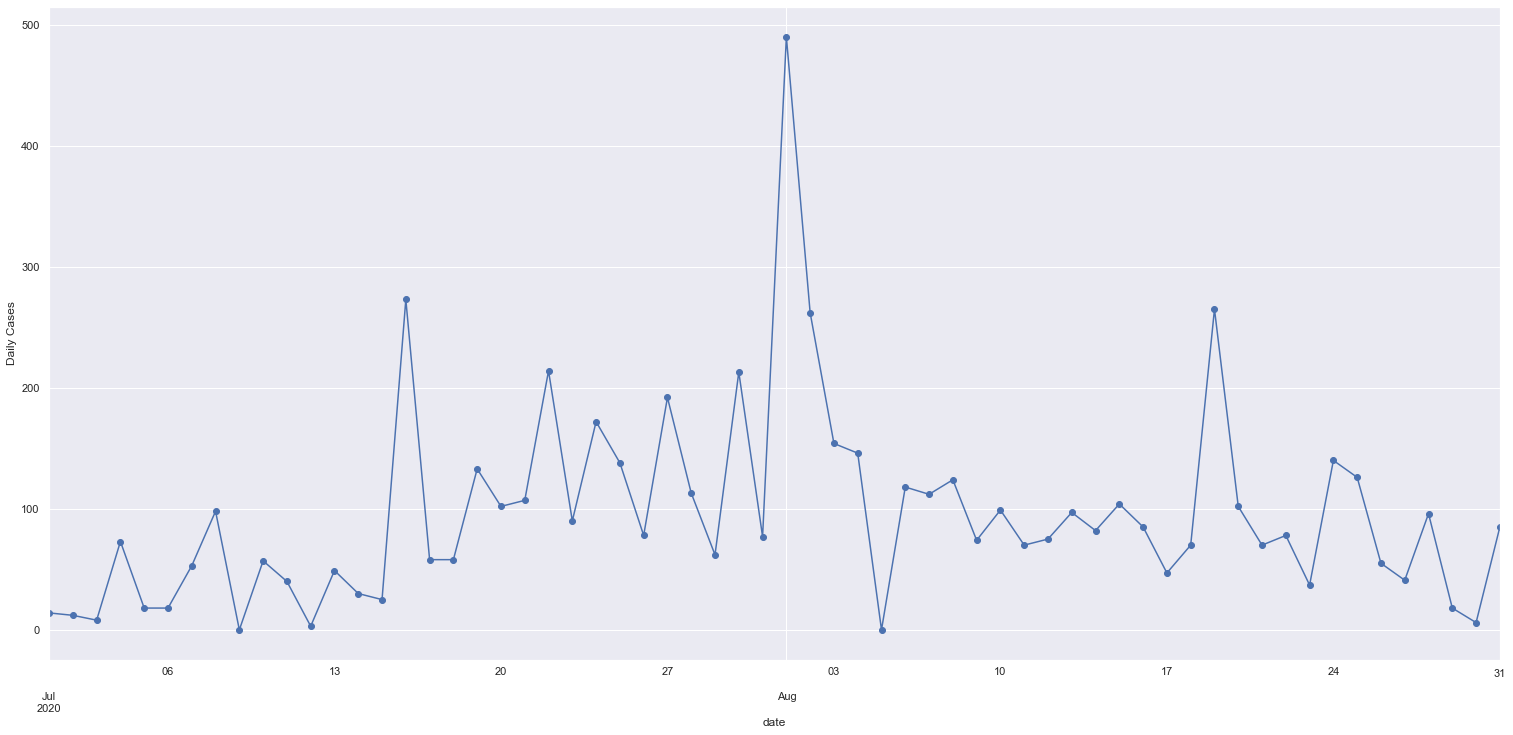

In [36]:
ax = dfTSA.loc['2020-07':'2020-08', 'new_cases'].plot(marker='o', linestyle='-',figsize=(26,12))
ax.set_ylabel('Daily Cases');

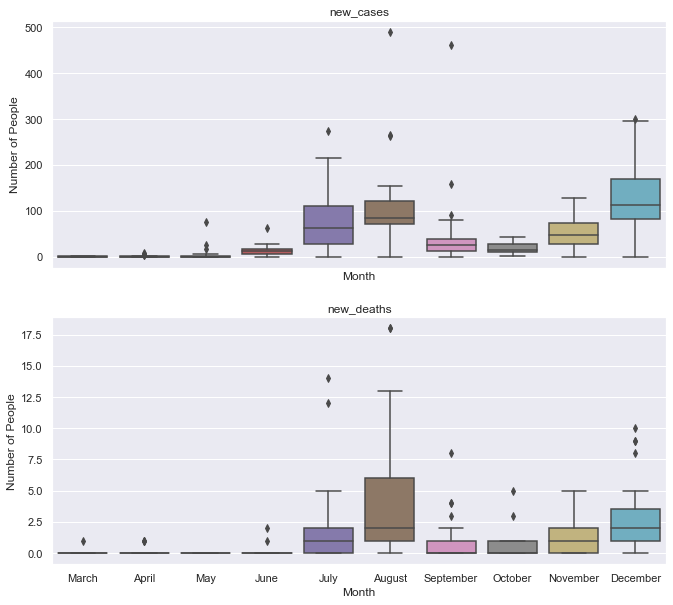

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['new_cases', 'new_deaths'], axes):
    sns.boxplot(data=dfTSA.loc['2020'], x='Month', y=name, ax=ax)
    ax.set_ylabel('Number of People')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

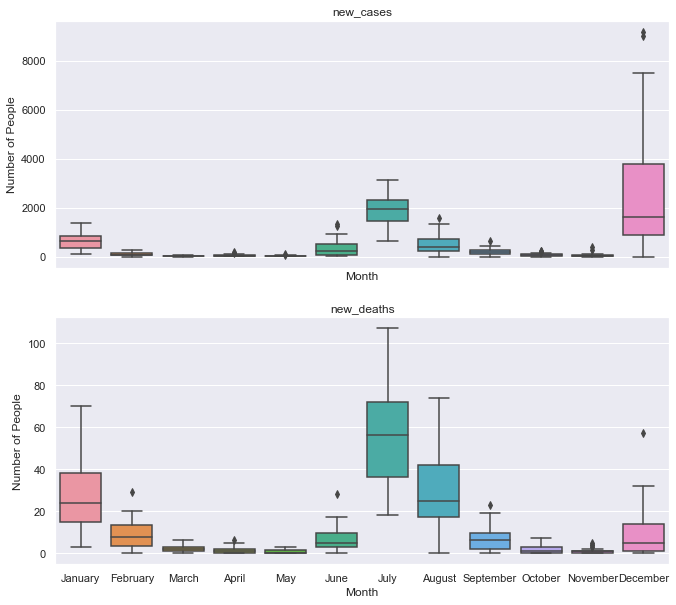

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['new_cases', 'new_deaths'], axes):
    sns.boxplot(data=dfTSA.loc['2021'], x='Month', y=name, ax=ax)
    ax.set_ylabel('Number of People')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

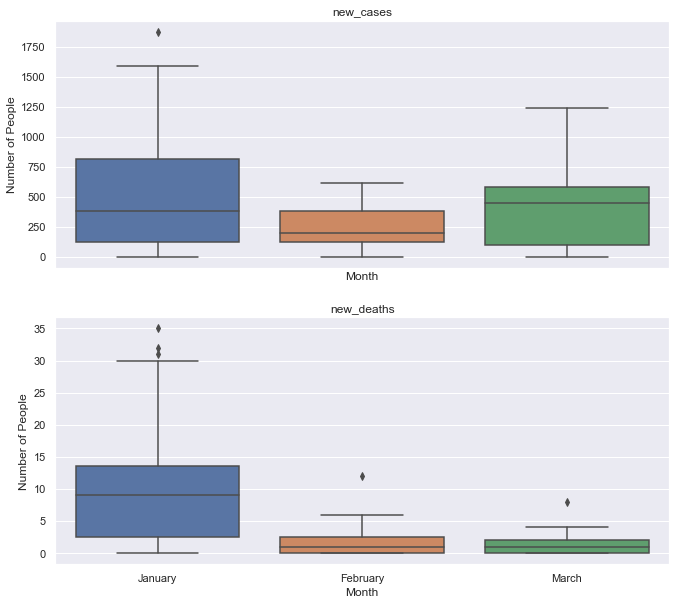

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['new_cases', 'new_deaths'], axes):
    sns.boxplot(data=dfTSA.loc['2022'], x='Month', y=name, ax=ax)
    ax.set_ylabel('Number of People')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

## Resampling our data
It is often useful to resample our time series data to a lower or higher frequency. Resampling to a lower frequency (downsampling) usually involves an aggregation operation
We will focus here on downsampling, exploring how it can help us analyze our OPSD data on various time scales. We use the DataFrame’s resample() method, which splits the DatetimeIndex into time bins and groups the data by time bin. 

In [40]:
# Specify the data columns we want to include 
data_columns = ['new_cases', 'new_deaths']
# Resample to weekly frequency, aggregating with mean
dfTSA_weekly_mean = dfTSA[data_columns].resample('W').mean()
dfTSA_weekly_mean.head(3)

,new_cases,new_deaths
date,,
2020-03-22,1.000000,0.000000
2020-03-29,0.571429,0.142857
2020-04-05,0.285714,0.000000


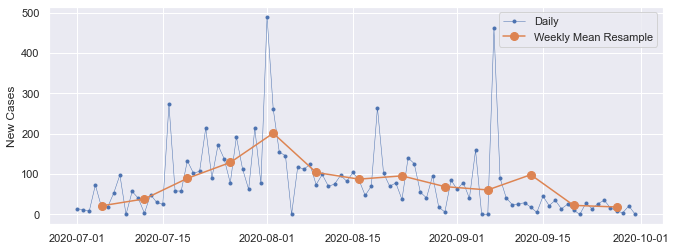

In [41]:
# Start and end of the date range to extract
start, end = '2020-07', '2020-09'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(dfTSA.loc[start:end, 'new_cases'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(dfTSA_weekly_mean.loc[start:end, 'new_cases'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('New Cases')
ax.legend();

We can see that the weekly mean time series is smoother than the daily time series because higher frequency variability has been averaged out in the resampling.

Now let’s resample the data to monthly frequency, aggregating with sum totals instead of the mean.

In [42]:
dfTSA_monthly = dfTSA[data_columns].resample('M').sum(min_count=28)
dfTSA_monthly.head(3)

,new_cases,new_deaths
date,,
2020-03-31,NaN,NaN
2020-04-30,32.0,3.0
2020-05-31,144.0,0.0


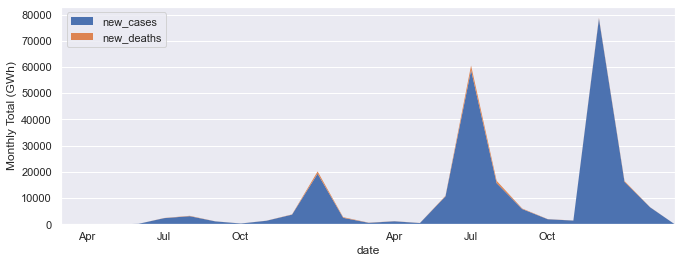

In [43]:
fig, ax = plt.subplots()
dfTSA_monthly[['new_cases', 'new_deaths']].plot.area(ax=ax, linewidth=0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');

## Rolling window
Rolling window operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as mean(), median(), sum(), etc. However, unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series.

In [44]:
dfTSA_7d = dfTSA[data_columns].rolling(7, center=True).mean()
dfTSA_7d.head(10)

,new_cases,new_deaths
date,,
2020-03-20,NaN,NaN
2020-03-21,NaN,NaN
2020-03-22,NaN,NaN
2020-03-23,0.428571,0.142857
2020-03-24,0.571429,0.142857
2020-03-25,0.571429,0.142857
2020-03-26,0.571429,0.142857
2020-03-27,0.571429,0.000000
2020-03-28,0.714286,0.000000


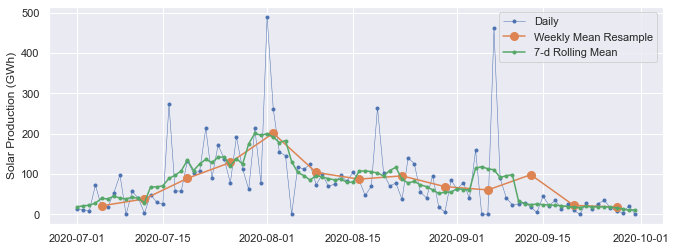

In [45]:
# Start and end of the date range to extract
start, end = '2020-07', '2020-09'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots()
ax.plot(dfTSA.loc[start:end, 'new_cases'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(dfTSA_weekly_mean.loc[start:end, 'new_cases'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(dfTSA_7d.loc[start:end, 'new_cases'],
marker='.', linestyle='-', label='7-d Rolling Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

We can see that data points in the rolling mean time series have the same spacing as the daily data, but the curve is smoother because higher frequency variability has been averaged out. In the rolling mean time series, the peaks and troughs tend to align closely with the peaks and troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled time series are less closely aligned with the daily time series, since the resampled time series is at a coarser granularity.

## Trends
Time series data often exhibit some slow, gradual variability in addition to higher frequency variability such as seasonality and noise. An easy way to visualize these trends is with rolling means at different time scales.

A rolling mean tends to smooth a time series by averaging out variations at frequencies much higher than the window size and averaging out any seasonality on a time scale equal to the window size. This allows lower-frequency variations in the data to be explored. Since our electricity consumption time series has weekly and yearly seasonality, let’s look at rolling means on those two time scales.

In [46]:
dfTSA_90d = dfTSA[data_columns].rolling(window=120, center=True).mean()

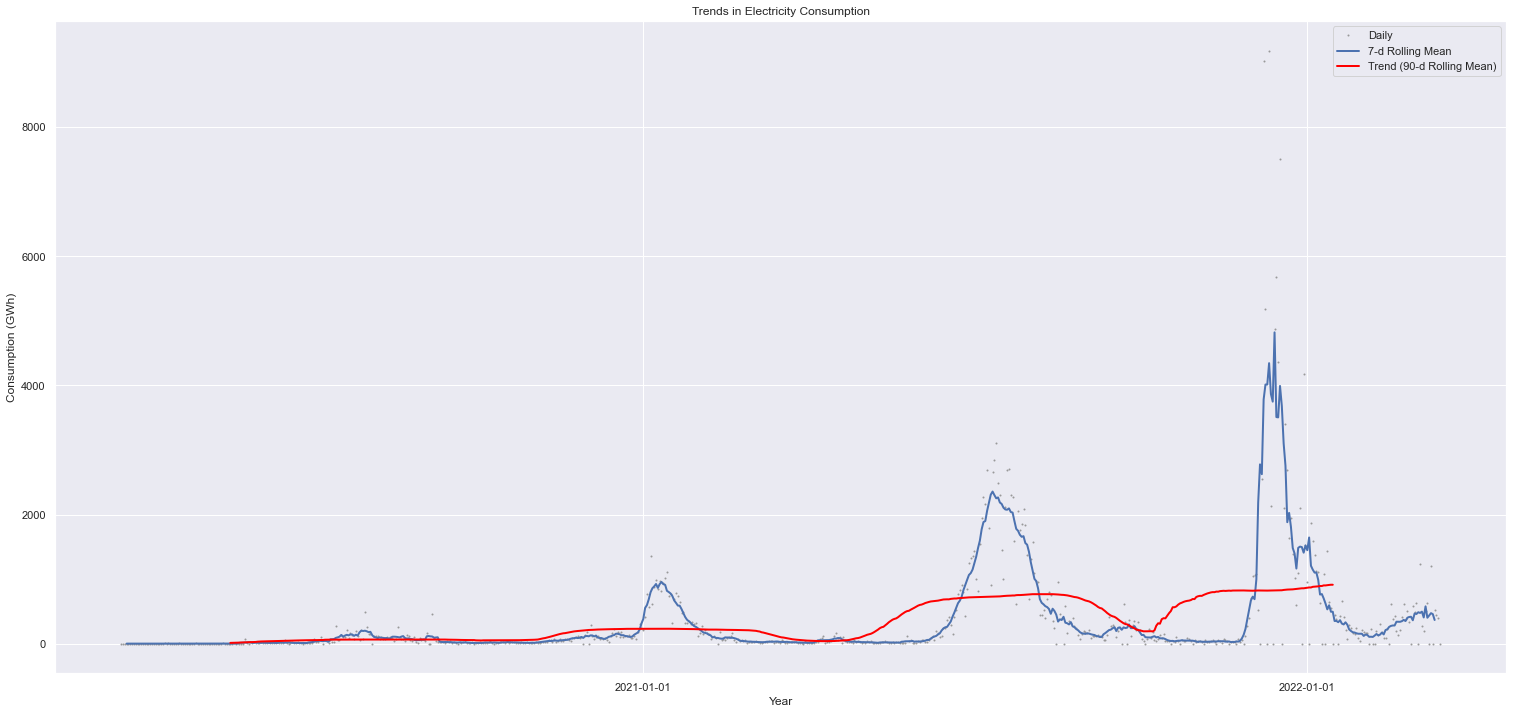

In [47]:
fig, ax = plt.subplots(figsize=(26,12))
ax.plot(dfTSA['new_cases'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(dfTSA_7d['new_cases'], linewidth=2, label='7-d Rolling Mean')
ax.plot(dfTSA_90d['new_cases'], color='red', linewidth=2,
label='Trend (90-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption');

In [48]:
dfTSA

,new_cases,new_deaths,Month
date,,,
2020-03-20,1.0,0.0,March
2020-03-21,2.0,0.0,March
2020-03-22,0.0,0.0,March
2020-03-23,0.0,1.0,March
2020-03-24,0.0,0.0,March
...,...,...,...
2022-03-11,0.0,0.0,March
2022-03-12,521.0,4.0,March
2022-03-13,446.0,2.0,March


## Check Stationarity of data

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.
Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.

Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.

###  a. Augmented Dickey-Fuller test

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [49]:
#Testing to see if new_cases values are stationary
from statsmodels.tsa.stattools import adfuller
X = dfTSA['new_cases'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.371658
p-value: 0.011964
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Since the p-value is 0.011964 which is less than 0.05 thus new_cases are stationary

In [50]:
#Testing to see if new_deaths values are stationary
from statsmodels.tsa.stattools import adfuller
X = dfTSA['new_deaths'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.791501
p-value: 0.000056
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Since the p-value is 0.011964 which is less than 0.05 thus new_cases are stationary

### a. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

The interpretaion of p-value is just the opposite of the ADF test. That is, if p-value is < signif level (say 0.05), then the series is non-stationary. 

In [51]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(dfTSA.new_deaths)

KPSS Statistic: 0.3986079741204086
p-value: 0.0777551835687894
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Benson\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


Since both tests ADF and KPSS confirmed that our data is stationary we skip step 3 in our TSA Process Flow and move on to the 4th step

### Pre-work for AR/MA :

#### a) Auto-correlation function (ACF) 
ACF is used to indicate and how similar a value is within a given time series and the previous value. It measures the degree of the similarity between a given time series and the lagged version of that time series at different intervals that we observed.
Python Statsmodels library calculates autocorrelation. This is used to identify a set of trends in the given dataset and the influence of former observed values on the currently observed values.

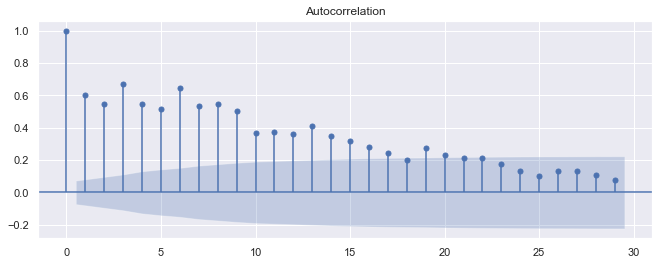

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(dfTSA.new_cases)

plt.show()

##### Interpreting the data:
1. The point outside the cone on x=0  has a 95% probability is has a certain impact on values
2. The previous number of cases influence the current number of cases, the significance of that influence decreases and slightly increases as shown in the above diagram


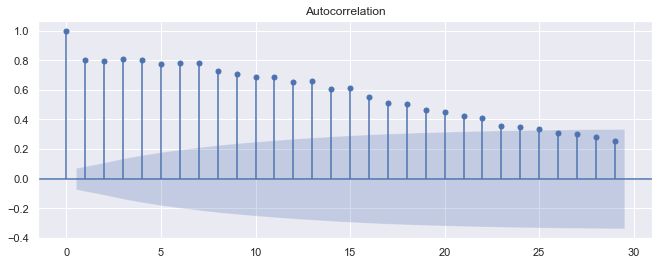

In [53]:
plot_acf(dfTSA.new_deaths)

plt.show()

Interpreting the data:
    
There is a strong influence of previous number of deaths to the current number of deaths, but this gradually decreases.



### Implementation steps for ARIMA

‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary.

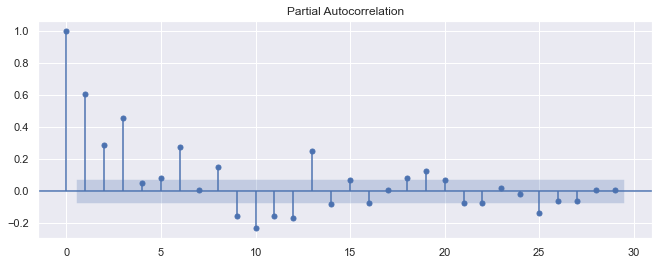

In [56]:
plot_pacf(dfTSA.new_cases)

plt.show()

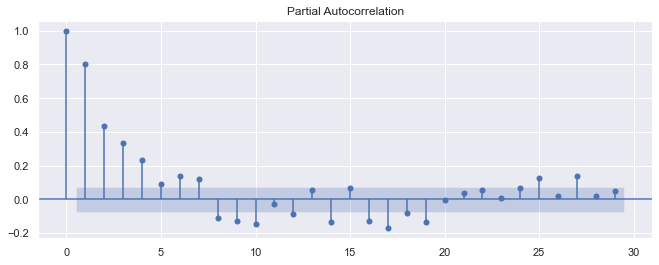

In [57]:
plot_pacf(dfTSA.new_deaths)

plt.show()

In [200]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 19) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 19)
SARIMAX: (0, 0, 1) x (0, 1, 0, 19)
SARIMAX: (0, 1, 0) x (0, 1, 1, 19)
SARIMAX: (0, 1, 0) x (1, 0, 0, 19)


In [201]:
import warnings
warnings.filterwarnings("ignore")

param_tabl = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(X_train["new_cases"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
            results = mod.fit()
            params = {"p,d,q": param, "P,D,Q,s": param_seasonal, "AIC": results.aic}
            param_tabl.append(params)
            #print('SARIMA: {} x {} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [202]:
param_tabl = pd.DataFrame(param_tabl)

In [203]:
print(len(param_tabl))
param_tabl[param_tabl["AIC"]==param_tabl["AIC"].min()]

64


,"p,d,q","P,D,Q,s",AIC
62,"(1, 1, 1)","(1, 1, 0, 19)",1094.408883


In [107]:
from sklearn.model_selection import train_test_split
#X_train, X_test = train_test_split(dfTSA.resample("W").sum(), test_size=0.2, random_state=1)

X_train = dfTSA.resample("W").sum().loc["2020-03-22":"2021-10-24"]
X_test = dfTSA.resample("W").sum().loc["2021-10-31":"2022-03-20"]

In [108]:
dfTSA.resample("W").sum().head()

,new_cases,new_deaths
date,,
2020-03-22,3.0,0.0
2020-03-29,4.0,1.0
2020-04-05,2.0,0.0
2020-04-12,5.0,2.0
2020-04-19,11.0,0.0


In [111]:
X_train["new_cases"].head(20)

date
2020-03-22       3.0
2020-03-29       4.0
2020-04-05       2.0
2020-04-12       5.0
2020-04-19      11.0
2020-04-26       6.0
2020-05-03       9.0
2020-05-10       2.0
2020-05-17       8.0
2020-05-24      12.0
2020-05-31     122.0
2020-06-07     104.0
2020-06-14     101.0
2020-06-21     106.0
2020-06-28      78.0
2020-07-05     149.0
2020-07-12     269.0
2020-07-19     626.0
2020-07-26     901.0
2020-08-02    1409.0
Freq: W-SUN, Name: new_cases, dtype: float64

In [204]:
train2_hat = sm.tsa.statespace.SARIMAX(X_train["new_cases"], order=(1,1,1), enforce_stationarity=True, seasonal_order=(1,1,0,19)).fit()
test2_hat = train2_hat.predict(start="2021-10-31", end="2022-03-20", dynamic=True) 

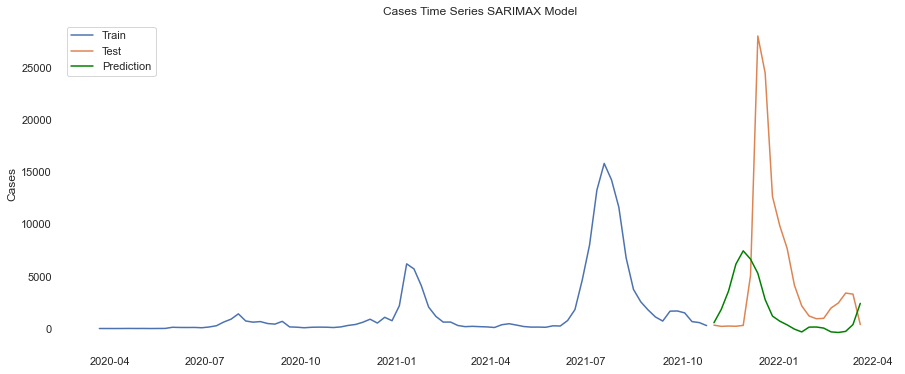

In [205]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(X_train["new_cases"], label="Train")
ax.set_ylabel("Cases")
ax.set_title("Cases Time Series SARIMAX Model")
ax.plot(X_test["new_cases"], label="Test")
ax.plot(test2_hat, color='green', label="Prediction")
#ax.plot(fit2.fittedvalues, color='green', linestyle="--", label="Fitted values (Train)")
ax.legend(loc="upper left")


sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [187]:
rms2 = sqrt(mean_squared_error(X_test["new_cases"], test2_hat))
rms2

8725.674249656

In [188]:
print(train2_hat.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6927      0.092     18.417      0.000       1.513       1.873
ar.L2         -0.7979      0.107     -7.451      0.000      -1.008      -0.588
sigma2      1.056e+06   2.16e+05      4.886      0.000    6.32e+05    1.48e+06


In [190]:
train2_hat.plot_diagnostics(figsize=(16, 10))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x720 with 0 Axes>

In [179]:
train2_hat = sm.tsa.statespace.SARIMAX(X_train["new_deaths"], order=(1,1,1), enforce_stationarity=True, seasonal_order=(1,1,0,19)).fit()
test2_hat = train2_hat.predict(start="2021-10-31", end="2022-03-20", dynamic=True) 

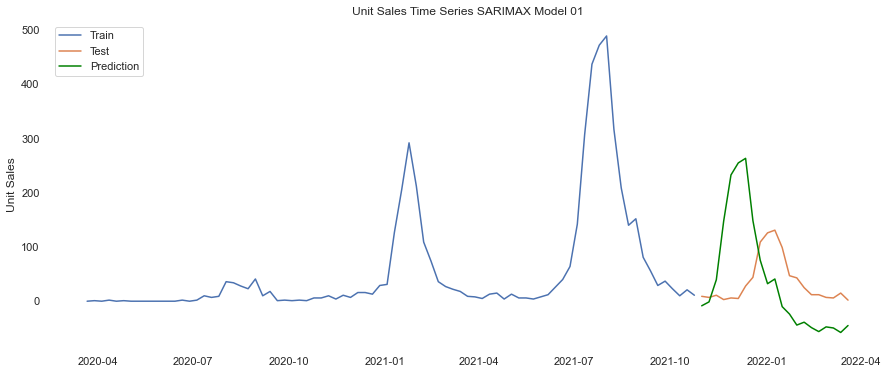

In [180]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(X_train["new_deaths"], label="Train")
ax.set_ylabel("Unit Sales")
ax.set_title("Unit Sales Time Series SARIMAX Model 01")
ax.plot(X_test["new_deaths"], label="Test")
ax.plot(test2_hat, color='green', label="Prediction")
#ax.plot(fit2.fittedvalues, color='green', linestyle="--", label="Fitted values (Train)")
ax.legend(loc="upper left")


sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [106]:
rms2 = sqrt(mean_squared_error(X_test["new_deaths"], test2_hat))
rms2

113.50931998110076

<AxesSubplot:xlabel='date'>

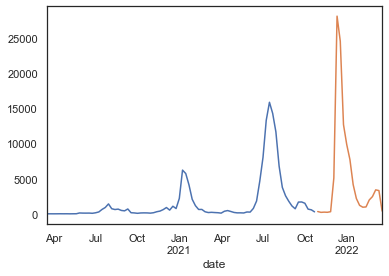

In [148]:
X_train['new_cases'].plot()
X_test['new_cases'].plot()

In [208]:
from pmdarima.arima import auto_arima
model_autoarima = auto_arima(X_train['new_cases'], seasonal=True,m=52)

In [209]:
model_autoarima

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 52),
      suppress_warnings=True)

In [197]:
train2_hat = sm.tsa.statespace.SARIMAX(X_train["new_cases"], order=(2,0,0), enforce_stationarity=True, seasonal_order=(0,1,0,52)).fit()
test2_hat = train2_hat.predict(start="2021-10-31", end="2022-03-20", dynamic=True) 

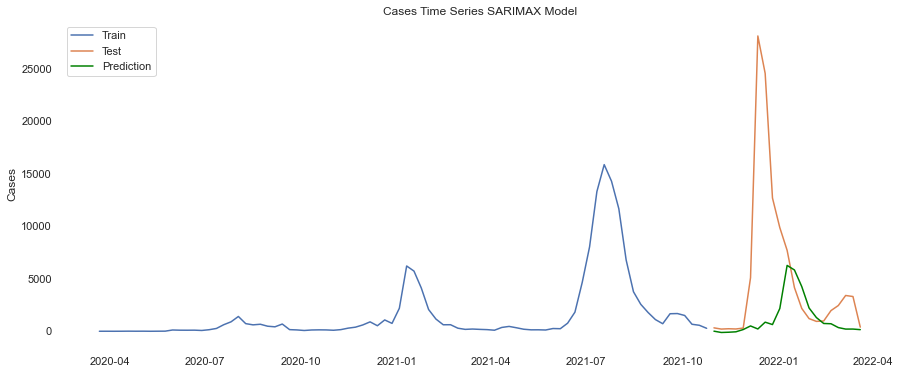

In [198]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(X_train["new_cases"], label="Train")
ax.set_ylabel("Cases")
ax.set_title("Cases Time Series SARIMAX Model")
ax.plot(X_test["new_cases"], label="Test")
ax.plot(test2_hat, color='green', label="Prediction")
#ax.plot(fit2.fittedvalues, color='green', linestyle="--", label="Fitted values (Train)")
ax.legend(loc="upper left")


sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [199]:
rms2 = sqrt(mean_squared_error(X_test["new_cases"], test2_hat))
rms2

8725.674249656

In [ ]:
mean_squared_error(y_true, y_pred)

In [193]:
model_autoarima = auto_arima(dfTSA['new_deaths'], seasonal=True,m=52)
model_autoarima

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [194]:
train2_hat = sm.tsa.statespace.SARIMAX(X_train["new_deaths"], order=(2,1,3), enforce_stationarity=True, seasonal_order=(0,0,0,52)).fit()
test2_hat = train2_hat.predict(start="2021-10-31", end="2022-03-20", dynamic=True) 

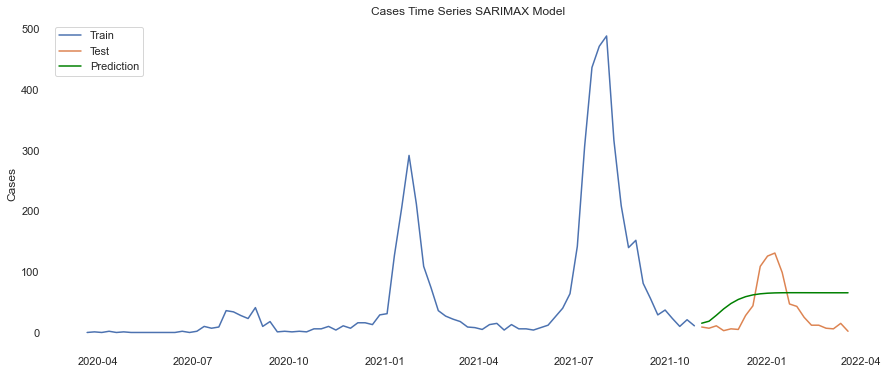

In [195]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(X_train["new_deaths"], label="Train")
ax.set_ylabel("Cases")
ax.set_title("Cases Time Series SARIMAX Model")
ax.plot(X_test["new_deaths"], label="Test")
ax.plot(test2_hat, color='green', label="Prediction")
#ax.plot(fit2.fittedvalues, color='green', linestyle="--", label="Fitted values (Train)")
ax.legend(loc="upper left")


sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [196]:
rms2 = sqrt(mean_squared_error(X_test["new_deaths"], test2_hat))
rms2

43.77481504360577

In [206]:
print(train2_hat.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4781      0.098      4.898      0.000       0.287       0.669
ma.L1          0.2870      0.132      2.168      0.030       0.028       0.546
ar.S.L19      -0.4846      0.142     -3.407      0.001      -0.763      -0.206
sigma2      1.352e+06   1.73e+05      7.811      0.000    1.01e+06    1.69e+06


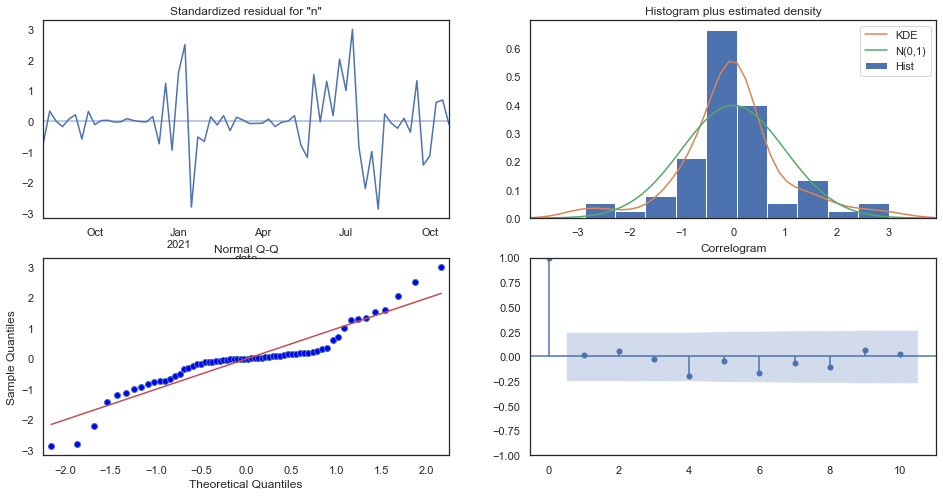

In [207]:
train2_hat.plot_diagnostics(figsize=(16, 8))
plt.show()

In [210]:
from prophet import Prophet


ModuleNotFoundError: No module named 'prophet'

In [212]:
dfTSA['temp']=dfTSA.index
dfTSA

,new_cases,new_deaths,Month,temp
date,,,,
2020-03-20,1.0,0.0,March,2020-03-20
2020-03-21,2.0,0.0,March,2020-03-21
2020-03-22,0.0,0.0,March,2020-03-22
2020-03-23,0.0,1.0,March,2020-03-23
2020-03-24,0.0,0.0,March,2020-03-24
...,...,...,...,...
2022-03-11,0.0,0.0,March,2022-03-11
2022-03-12,521.0,4.0,March,2022-03-12
2022-03-13,446.0,2.0,March,2022-03-13


In [214]:
newCases=dfTSA[['temp','new_cases']]

In [ ]:
m = Prophet()
m.fit(newCases)

In [ ]:
futureCases = m.make_future_dataframe(periods=365)
forecast = m.predict(futureCases)
forecast[['Date', 'cases', 'cases_lower', 'cases_upper']].tail()
